# CitiBike 

## Preliminary Wrangling

This document explores a dataset containing over 17 million bike trips from NYC in 2018.

In [6]:
# import all packages and set plots to be embedded inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

%matplotlib inline

In [2]:
# load data set in pandas dataframe
files = glob.glob('data/*.csv')
df = pd.DataFrame()
columns = ['tripduration', 'starttime', 'start station id', 'end station id',
           'usertype', 'birth year', 'gender']
for file in files:
    df_tmp = pd.read_csv(file, usecols=columns)
    df = pd.concat([df, df_tmp])

In [14]:
# high-level overview of the dataset
print('shape' , df.shape)
print(df.info())

shape (17548339, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17548339 entries, 0 to 1307542
Data columns (total 7 columns):
tripduration        int64
starttime           object
start station id    float64
end station id      float64
usertype            object
birth year          int64
gender              int64
dtypes: float64(2), int64(3), object(2)
memory usage: 1.0+ GB
None


In [15]:
df.head()

,tripduration,starttime,start station id,end station id,usertype,birth year,gender
0,681,2018-08-01 00:00:07.3210,3162.0,3383.0,Subscriber,1986,1
1,625,2018-08-01 00:00:19.7480,3260.0,2012.0,Subscriber,1969,1
2,1319,2018-08-01 00:00:21.1750,403.0,285.0,Subscriber,1970,1
3,220,2018-08-01 00:00:26.4700,3637.0,399.0,Subscriber,1982,1
4,398,2018-08-01 00:00:30.2910,3662.0,3517.0,Subscriber,1987,1


In [16]:
# replace spaces in column names to underscore
df.columns = [col.strip().replace(' ', '_') for col in df.columns]

# change starttime column from string to datetime
df.starttime = pd.to_datetime(df.starttime)

# create dummy variables
df['month'] = df.starttime.dt.month_name()
df['month_day'] = df.starttime.dt.day
df['week_day'] = df.starttime.dt.day_name()
df['hour'] = df.starttime.dt.hour

## Raised Questions
* In order to predict future number of trips, What variables effect the number of trips?
* Does the trip duration has any correlation with other variables ?

## Univariate Exploration

In [40]:
# setting defualt color for all plots
base_color = sns.color_palette()[0]

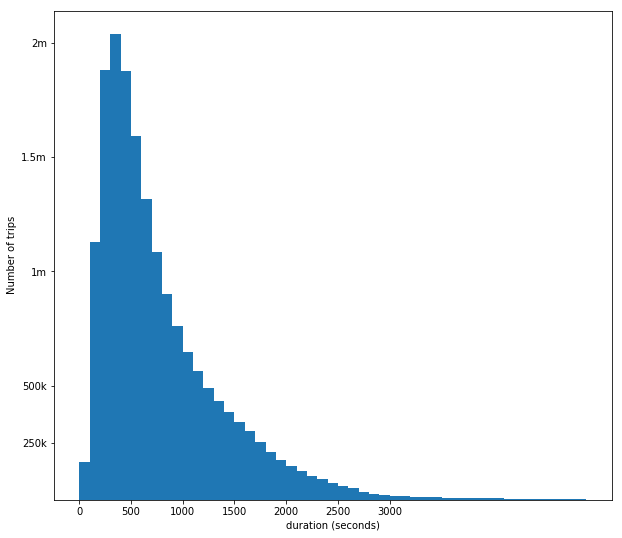

In [68]:
# starting plotting trip duration distribution
plt.figure(figsize=(10,9))
bins = np.arange(0, 5000, 100)
df.tripduration.plot(kind='hist', bins=bins)
plt.yticks([25e4,5e5,1e6,15e5,2e6],['250k','500k','1m','1.5m','2m'])
plt.xticks(range(0,3500,500))
plt.ylabel('Number of trips')
plt.xlabel('duration (seconds)');

The plot is skewed to right, Most of trips are around 200 to 700 seconds long.

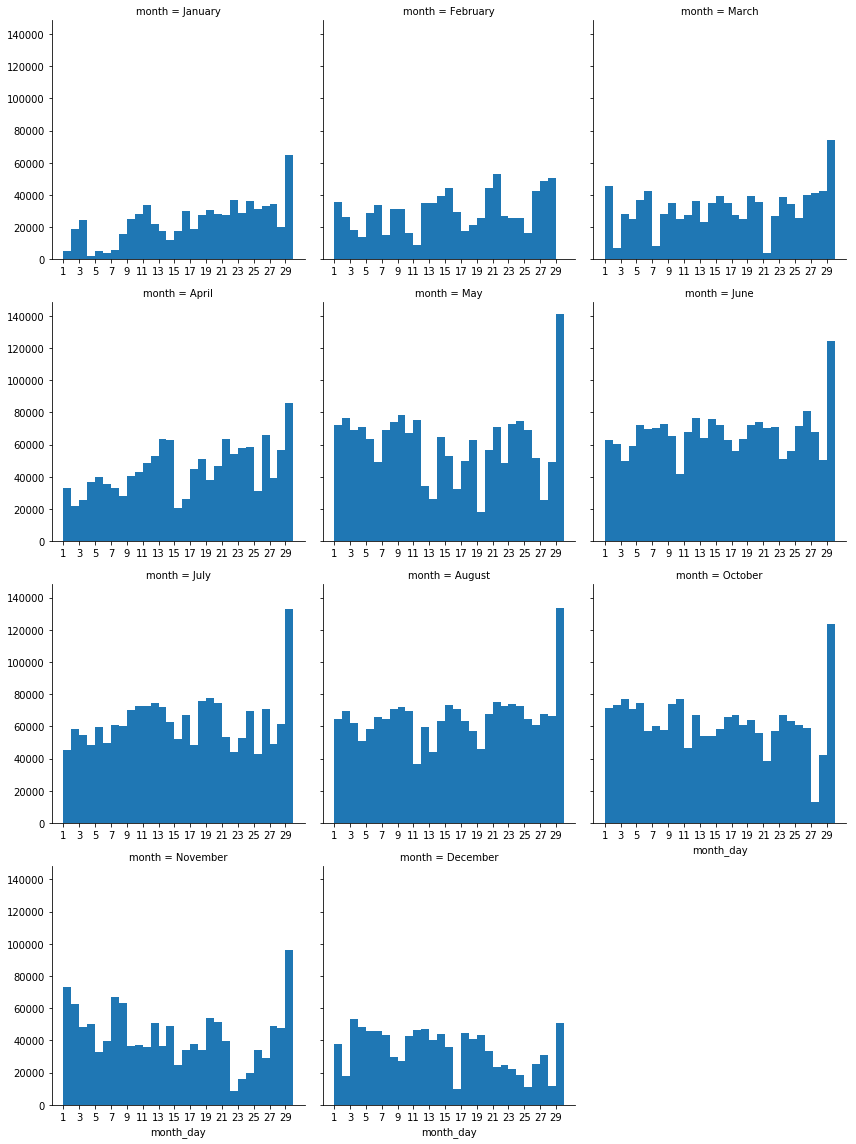

In [71]:
# let's plot daily trips in the whole year

#first lets order the months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'October', 'November', 'December']

# ploting each month seperatly
g = sns.FacetGrid(df, col='month', col_wrap=3, sharex=False, height=4, col_order=month_order)
g.map(plt.hist, 'month_day', bins=np.arange(1,31,1))
g.set(xticks=np.arange(1,31,2));

As we can see there are spikes in each month end. 

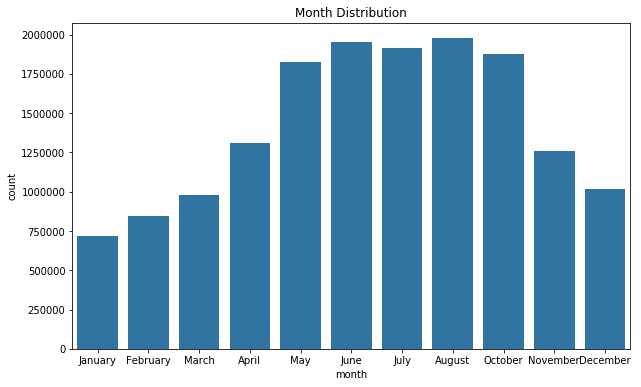

In [84]:
# lets plot how many total trips each month
plt.figure(figsize=(10,6))
sns.countplot(df.month, order=month_order, color=base_color);
plt.title('Month Distribution')
plt.show()

as we can see there is a peak from May to October.

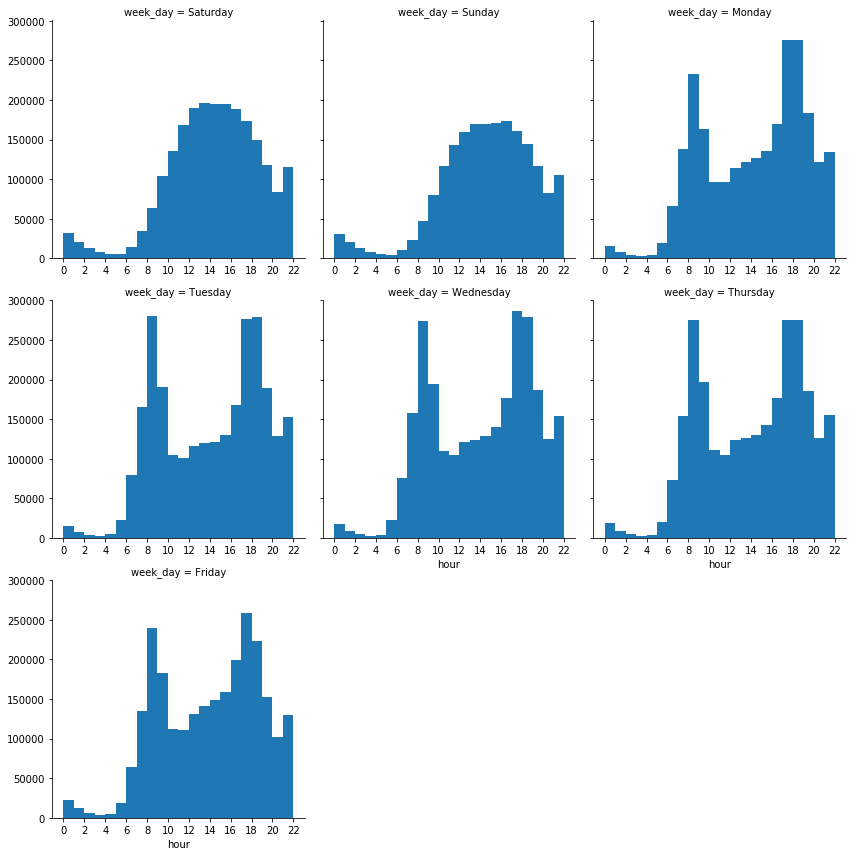

In [20]:
# let's plot each hour trips among week days

# first let's order week days
week_day_order = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

g = sns.FacetGrid(df, col='week_day', col_wrap=3, sharex=False, height=4, col_order=week_day_order)
g.map(plt.hist, 'hour',bins=np.arange(0,23,1))
g.set(xticks=np.arange(0,23,2));

It is clear that business days has two spikes first one at 7-8 and another one at 17-18. The weekends has wide range spike form 10-19.

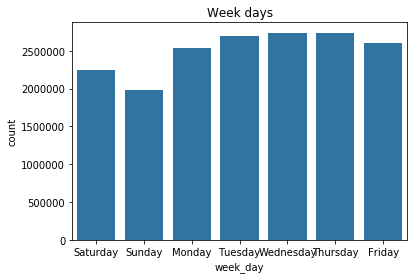

In [77]:
# lets plot total trips for week days 
sns.countplot(df.week_day, order=week_day_order, color=base_color);
plt.title('Week days')
plt.show()

As we can see business days have more trips that weekends.

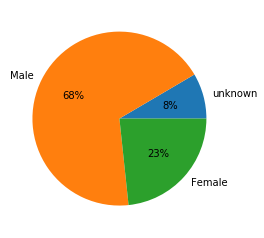

In [88]:
# lets plot gender distribution of the dataset
label = ['unknown', 'Male', 'Female']
df.groupby('gender').size().plot(kind='pie',labels=label,  autopct='%1.0f%%')
plt.ylabel('');

The majority of users are Male with 68% and the Female are 23%. The other 8% are unkown.

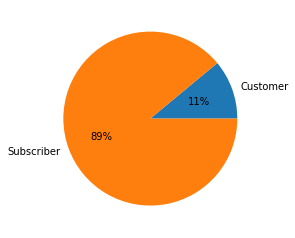

In [87]:
# lets plot user-type distribution 
df.groupby('usertype').size().plot(kind='pie', autopct='%1.0f%%')
plt.ylabel('');

Subscribers made 89% perecente of the trips, and Customers made 11%.

In [2]:
# let's plot the birth-year distribution
plt.figure(figsize=(10,8))

max_birth = df.birth_year.max()
bins = np.arange(1940, max_birth + 1, 1)
labels=np.arange(1940, max_birth + 5, 5)

plt.hist(df.birth_year,bins=bins, color=base_color)
plt.xticks(labels);
plt.xlim(1940, max_birth);

NameError: name 'plt' is not defined

The shape is sekwed to left, with one big spike in year 1969. Most of the trips made by people born between 1985 to 1993. The year 1969 will be investigated later on.

## Bivirate exploration

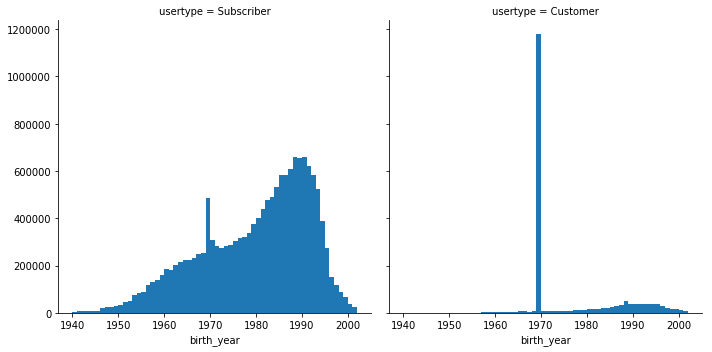

In [113]:
g = sns.FacetGrid(df, col='usertype', height=5)
bins = np.arange(1940, max_birth + 1, 1)
g.map(plt.hist, 'birth_year', data=df, bins=bins)
g.set(xticks=np.arange(1940, max_birth + 5, 10))

As we can see that most of customers born on 1969. This is unrealistic, this is an quality issue. Any way in the year investigation I will rely on subscribers birth year. To avoid 1969 this issue.

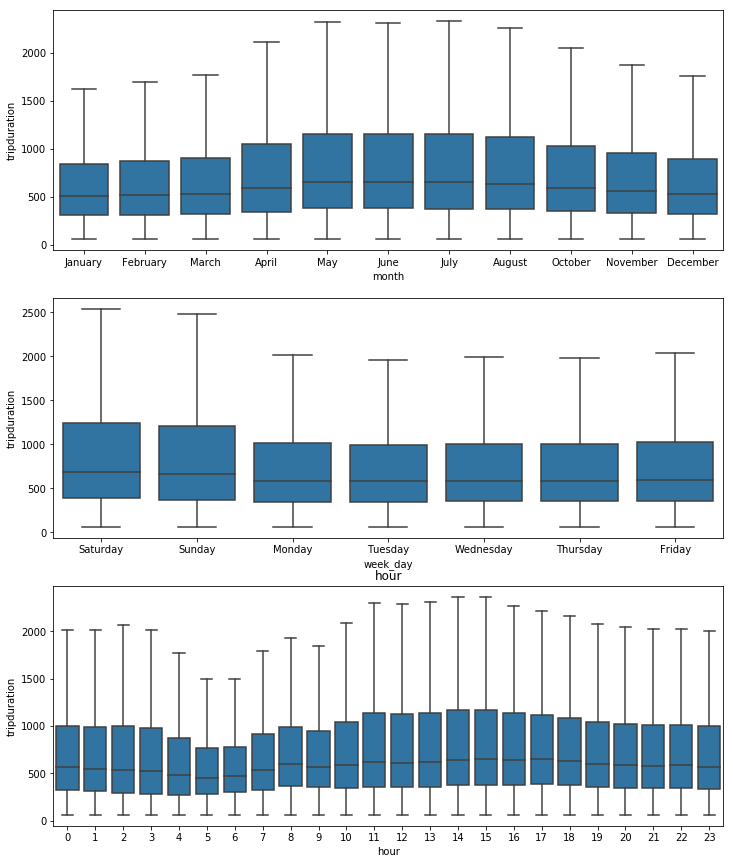

In [114]:
# let's plot the trip-duration sitribution among month , week_days and hours 
fig, ax = plt.subplots(nrows=3, figsize=(12,15))

plt.title('month')
sns.boxplot(df.month, df.tripduration, showfliers=False, order=month_order, color=base_color, ax=ax[0])

plt.title('week day')
sns.boxplot(df.week_day, df.tripduration, showfliers=False, order=week_day_order, color=base_color, ax=ax[1])

plt.title('hour')
sns.boxplot(df.hour, df.tripduration, showfliers=False, color=base_color, ax=ax[2])

plt.show()

From April to August trips have long duration. Business days has less duration than weekends. Trips made at hour 5 and 6 has less duration long but, there is little spike from hour 11 to 15. 

/home/srap/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


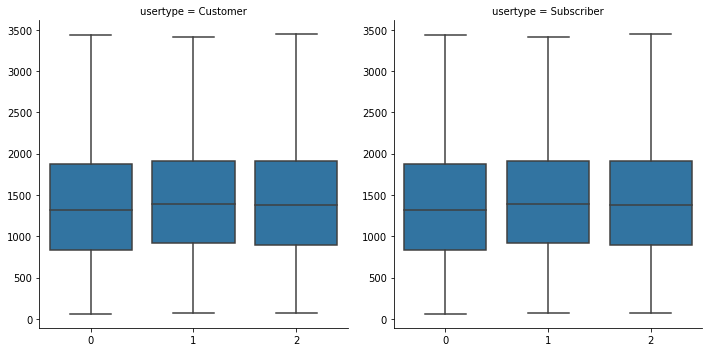

In [103]:
# let's plot the trip duration for each gender
gender_df = df.groupby(['start_station_id','end_station_id','gender','usertype']). tripduration.mean().reset_index()
g = sns.FacetGrid(gender_df, col='usertype', sharey=False, height=5)
g.map(sns.boxplot, x='gender', y='tripduration', showfliers=False, data=gender_df)
plt.show()

I made a decision by grouping by start and end stations. I wanted to see if specefic gender tend to take longer duration for the same trips. The resualt shows that varies genders almost take the same trip long.

## Multivariate Exploration

(1940, 2010)

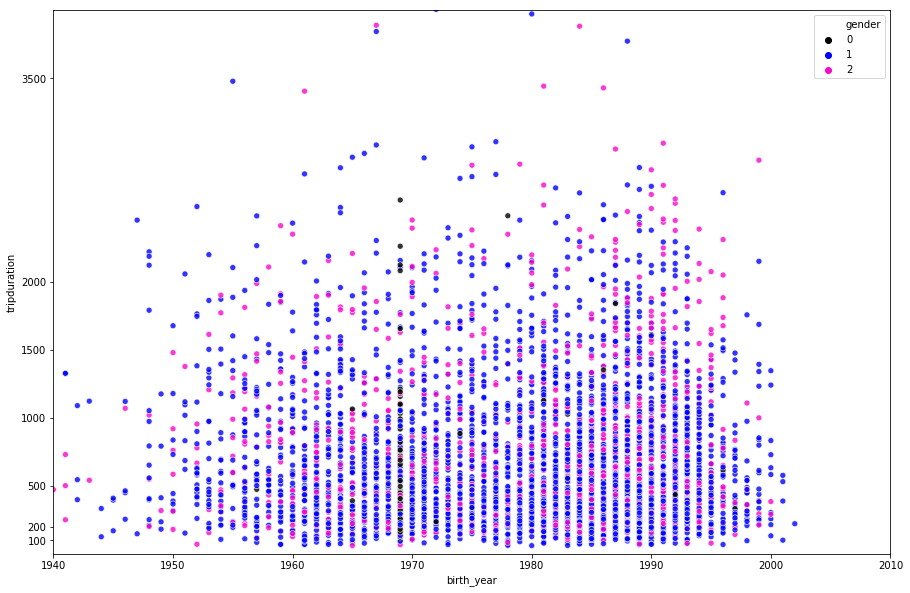

In [131]:

plt.figure(figsize=(15,10))
colors = ['black','blue', '#f709cb']
sns.scatterplot('birth_year', 'tripduration', hue='gender',alpha=.80, x_jitter = 0.3, palette=colors,
                data=df.query('usertype == "Subscriber"').sample(5000))
plt.yticks([100,200,500,1000,1500,2000,3500])
plt.ylim(0,4000)
plt.xlim(1940,2010);